In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import shap
import sklearn
import math
import sys

from general_code import datasets, functions
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from datetime import datetime
from statistics import mode, median, mean 
from importlib import reload  

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


# Investigating the use of SHAP values to existing fairness measures

### Current work on fairness

As the use of decision making algorithms is increasing, so does the want for a proof of fairness of these algorithms. The discussion about many different possible fairness measures is therefore rising as well. 

### Current work on SHAP

Apart from the need to verify the fairness of an algorithm, understanding its workings is of great importance as well. Of the currently available methods, SHAP is the most unified approach.

### The models 

To explore the usefulness of SHAP in fairness assessment, two classification models were created. One model is based on the COMPAS dataset and predicts recidivism and the second model is based on the German Credit Risk dataset and predicts the risk of giving a loan. 

### Methods to improve or enhance fairness measures:
#### 1. Correlation between SPD and SHAP values
#### 2. Using SHAP distance to compute Individual Fairness
#### 3. Explaining existing methods with SHAP values

## The models

The models were made using existing datasets which are known to be biased, thus creating biased models as well. The models are both random forest models, created with the RandomForestClassifier from the scikit-learn library. To make the data suitable for such a model, it was first preproccesed. This preprocessing consisted of making the data numerical and of appropriate format.

The recidivism model is based on 33 attributes and consists of 8952 samples. The output is 0 (will not recidivate) or 1 (will recidivate). The credit model is based on 38 attributes and consists of 1000 samples. The output is 0 (low risk) or 1 (high risk).


In [2]:
def get_data(dataset, include_sex = True):
    if dataset == 'compas':
        protected_att = ['sex_male', 'race_black']
        conditional_att = ['p_arrest']
        data = datasets.compas(include_sex)
    elif dataset == 'german_credit':
        protected_att = ['f_div/sep/mar']
        conditional_att = ['credit_account_status']
        data = datasets.german_credit(include_sex)
    X_train, X_test, y_train, y_test = data
    return protected_att, conditional_att, X_train, X_test, y_train, y_test
    
protected_att, conditional_att, X_train, X_test, y_train, y_test = get_data('german_credit')
print(np.shape(X_train), np.shape(X_test))
print(X_train.columns)

(800, 38) (200, 38)
Index(['credit_account_status', 'duration', 'credit_history', 'credit_amount',
       'saving_account', 'employment_since', 'installment_rate',
       'present_residence_since', 'property', 'age', 'existing_credits', 'job',
       'liable_people', 'telephone', 'foreign_worker', 'purpose_business',
       'purpose_car_(new)', 'purpose_car_(used)',
       'purpose_domestic_appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_others',
       'purpose_radio/television', 'purpose_repairs', 'purpose_retraining',
       'f_div/sep/mar', 'm_div/sep', 'm_mar/wid', 'm_single',
       'debtor_co-applicant', 'debtor_guarantor', 'debtor_none',
       'inst_plan_bank', 'inst_plan_none', 'inst_plan_stores',
       'housing_for_free', 'housing_own', 'housing_rent'],
      dtype='object')


In [3]:
# Build the model with the random forest classifier algorithm:
model = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)

# Test the model:
y_pred = model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))


[[133   8]
 [ 49  10]]
0.715


In [4]:
#Calculate SHAP values
explainer = shap.TreeExplainer(model, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_test)
global_shap_values = shap_values[1].mean(0)

## Methods to improve or enhance fairness measures:
### 1. Correlation between fairness measures and SHAP values
One way the SHAP values could prove to be usefull is if they could be used to replace existing measures. The intuitive nature of SHAP values could make them a better alternative than the existing measures. To find out whether the SHAP values are in some way related to the measures, the correlation between them is calculated. 

**Statistical Parity:**

The first fairness measure that was compared to SHAP values is the notion of statistical parity (also called group fairness, equal acceptance rate or benchmarking). This notion is satisfied if all groups have equal outcomes. The statistical parity difference (SPD) is then a measure of the difference of outcomes between groups. If all groups have similar outputs, that means that the attribute that devides these groups should have no impact on the output of the model. The impact on the model can be measured with SHAP values. It would therefore be a logical conclusion that if the SPD is low, the protected attribute should also have a low global SHAP value. We would thus expect to find a correlation between the SPD when split on a certain attribute and the global SHAP value of this attribute. 

To test this hypothesis, the SPD and the global SHAP value are computed for all features. Many of the features are not so called 'protected attributes', but the same behaviour is expected for features that are not considered 'protected'. SHAP is primarily a local explanation method. To generate global explanations from SHAP, the average SHAP value is computed for each unique feature value. This results in a global SHAP value that captures the average attribution of a specific feature value (for instance age = 21) to the model output. The statistical parity difference is then computed between the group with that value and the group with any other value. The SPD and the SHAP value of each feature value are computed and plotted against each other. The Pearson correlation coefficient will then show the correlation between the two variables. 

In [ ]:
def spd_shap(col, value):
    #Split data
    X_test_a = X_test.loc[X_test[col] == value]
    X_test_b = X_test.loc[X_test[col] != value]
    y_pred_a = model.predict(X_test_a)
    y_pred_b = model.predict(X_test_b)
    #Compute spd
    spd = functions.statistical_parity_difference(y_pred_a, y_pred_b)
    #Get global SHAP
    att_idx = X_train.columns.get_loc(col)
    shap = shap_values[1][:, att_idx][X_test[col] == value].mean()
    
    if(col == 'age' and value == 21 ):
        print(col, value, shap)
    return spd, shap

spd_vals = []
shap_vals = []       

for col in X_test.columns:
    if np.size(X_test[col].unique()) <= 1:
        print(col, ' does not have enough different samples')
    else:
        for value in X_test[col].unique():
            spd_val, shap_val = spd_shap(col, value)
            spd_vals.append(spd_val)
            shap_vals.append(shap_val)

#Plot the SPD and SHAP
plt.plot(spd_vals, shap_vals, 'ro')
plt.xlabel('spd')
plt.ylabel('shap')
plt.show()

corrcoef = np.corrcoef(spd_vals, shap_vals)
print(corrcoef)

**Conditional Statistical Parity:**

The second fairness measure that was compared to SHAP values is conditional statistical parity. An algorithm statisfies this definition if subjects in both groups have equal outcomes, when controlling for some legitimate factors. It thus extends the notion of statistical parity. Conditional statistical parity difference (CSPD) measures the difference of the outcomes of the groups, when some factors are controlled. As this notion extends the notion of statistical parity, it can be expected that CSPD has a similar relation to SHAP values as SPD has.

To test this hypothesis, the CSPD has to be calculated for all features. Again two groups are created based on each feature value, where one group has that value for that feature and the other group does not have that value for the feature. Then for each possible value of the controlling features, subgroups are created from these groups. The SPD is calculated for each of these subgroups that have the same controlling feature value. The average of these SPD's is then the SPD for that feature value.




In [ ]:
def cspd_shap(col, value):
    #Split data
    X_test_a = X_test.loc[X_test[col] == value]
    X_test_b = X_test.loc[X_test[col] != value]
    y_pred_a = model.predict(X_test_a)
    y_pred_b = model.predict(X_test_b)
    #Compute spd
    cspd = functions.conditional_statistical_parity_difference(conditional_att, X_test, X_test_a, y_pred_a, X_test_b, y_pred_b)
    #Get global SHAP
    att_idx = X_train.columns.get_loc(col)
    shap = shap_values[1][:, att_idx][X_test[col] == value].mean()
    return cspd, shap

cspd_vals = []
for col in X_test.columns:
    if np.size(X_test[col].unique()) <= 1:
        print(col, ' does not have enough different samples')
    else:
        for value in X_test[col].unique():
            cspd_val, _ = cspd_shap(col, value)
            cspd_vals.append(cspd_val)

#Plot the SPD and SHAP
plt.plot(cspd_vals, shap_vals, 'ro')
plt.xlabel('cspd')
plt.ylabel('shap')
plt.show()


corrcoef = np.corrcoef(cspd_vals, shap_vals)
print(corrcoef)

**Equal opportunity:**

The third fairness measure that was compared to SHAP values is equal opportunity. An algorithm statisfies this definition if subjects in both groups have the same false negative rate. The groups have the same probability of falsly beining predicted the negatative class. SHAP values do not tell us anything about what the correct prediction would be, thus also not about the false negative rate. The expectation is therefore that the relation between SHAP and equal opportunity is less strong.

In [ ]:
def eod_shap(col, value):
    #Split data
    X_test_a = X_test.loc[X_test[col] == value]
    X_test_b = X_test.loc[X_test[col] != value]
    y_test_a = y_test.loc[X_test[col] == value]
    y_test_b = y_test.loc[X_test[col] != value]
    y_pred_a = model.predict(X_test_a)
    y_pred_b = model.predict(X_test_b)
    
    #Compute eod
    eod = functions.equal_opportunity_difference(y_pred_a, y_pred_b, y_test_a, y_test_b)
    
    #Get global SHAP
    att_idx = X_train.columns.get_loc(col)
    shap = shap_values[1][:, att_idx][X_test[col] == value].mean()
    return eod, shap

eod_vals = []
shap_vals_eod = []
for col in X_test.columns:
    if np.size(X_test[col].unique()) <= 1:
        print(col, ' does not have enough different samples')
    else:
        for value in X_test[col].unique():
            eod_val, shap_val_eod = eod_shap(col, value)
            if eod_val != -1:
                eod_vals.append(eod_val)
                shap_vals_eod.append(shap_val_eod)

#Plot the SPD and SHAP
plt.plot(eod_vals, shap_vals_eod, 'ro')
plt.xlabel('eod')
plt.ylabel('shap')
plt.show()


corrcoef = np.corrcoef(eod_vals, shap_vals_eod)
print(corrcoef)

**Overall accuracy equality:**

The fourth fairness that was compared to SHAP values is the overall accuracy equality. An algorithm statisfies this definition if subjects in both groups have the same accuracy. As this measure also needs to know the correct prediction, the expactatation is again that the relation with SHAP is minimal.

In [ ]:
def oaed_shap(col, val):
    #Split data
    X_test_a = X_test.loc[X_test[col] == value]
    X_test_b = X_test.loc[X_test[col] != value]
    y_test_a = y_test.loc[X_test[col] == value]
    y_test_b = y_test.loc[X_test[col] != value]
    y_pred_a = model.predict(X_test_a)
    y_pred_b = model.predict(X_test_b)
    
    #Compute eod
    oaed = functions.overall_accuracy_equality_difference(y_pred_a, y_pred_b, y_test_a, y_test_b)

    #Get global SHAP
    att_idx = X_train.columns.get_loc(col)
    shap = shap_values[1][:, att_idx][X_test[col] == value].mean()
    return oaed, shap

oaed_vals = []
shap_vals_oaed = []
for col in X_test.columns:
    if np.size(X_test[col].unique()) <= 1:
        print(col, ' does not have enough different samples')
    else:
        for value in X_test[col].unique():
            oaed_val, shap_val_oaed = oaed_shap(col, value)
            if eod_val != -1:
                oaed_vals.append(oaed_val)
                shap_vals_oaed.append(shap_val_oaed)

#Plot the SPD and SHAP
plt.plot(oaed_vals, shap_vals_oaed, 'ro')
plt.xlabel('oaed')
plt.ylabel('shap')
plt.show()


corrcoef = np.corrcoef(oaed_vals, shap_vals_oaed)
print(corrcoef)

### 2. Using SHAP distance to compute Individual Fairness

Another way SHAP can be of use, is to improve an existing fairness measure. One fairness measure which could be improved using SHAP is the notion of Individual Fairness. An algorithm satisfies this notion of fairness if similar samples have similar output. Different metrics can be used to determine the similarity between samples. Most of the time, the similarity is computed based on the features. If two samples have similar features, the samples are considered similar as well. However, the features are often on different scale, which makes it difficult to compute similarity of such different features. To improve this notion of Individual Fairness, the similarity of samples can also be computed using SHAP values. If two samples have similar SHAP values, the samples are considered similar as well. Because SHAP values all have the same unit, determining similarity will become easier and more accurate. 

To test whether the use of SHAP values in this context truly improves the notion of Individual Fairness, certain aspects are looked at. First, the individuals who do not receive individual fairness are analyzed. These individuals can receive either a positive or negative bias. The expectation is that certain groups that have proven to be treated unfair, also receive unfair treatment based on the notion of Individual Fairness. 

In [ ]:
#Calculate Individual Fairness with d(i,j) = euclidean_distance(i,j)
#Scale the data
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X_test_scaled)
_, indices_orig = nbrs.kneighbors(X_test_scaled)

consistency_orig, negative_bias_orig, positive_bias_orig = functions.consistency(X_test, y_pred, indices_orig)

#Calculate Individual fairness with d(i,j) = euclidean_distance(shap(i), shap(j))
def shap_dist(x,y):
    shap_values_x = explainer.shap_values(x)
    shap_values_y = explainer.shap_values(y)
    return functions.euclidean_distance(shap_values_x[1], shap_values_y[1])
    
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric= shap_dist ).fit(X_test_scaled)
distances_shap, indices_shap = nbrs.kneighbors(X_test_scaled)

consistency_shap, negative_bias_shap, positive_bias_shap = functions.consistency(X_test, y_pred, indices_shap)

print(consistency_orig)
print(consistency_shap)

print(np.shape(negative_bias_orig), np.shape(positive_bias_orig))
print(np.shape(negative_bias_shap), np.shape(positive_bias_shap))

In [ ]:
def check_bias(negative_bias, positive_bias):
    female_neg = 0
    male_neg = 0
    for idx, i in enumerate(negative_bias):
        if i['f_div/sep/mar'] ==1:
            female_neg += 1
        else:
            male_neg += 1
    female_pos = 0
    male_pos = 0       
    for idx, i in enumerate(positive_bias):
        if i['f_div/sep/mar'] ==1:
            female_pos += 1
        else:
            male_pos += 1
    female_ratio =female_neg/(female_pos+female_neg)
    male_ratio = male_neg/(male_pos+male_neg)
    
    print('pos/neg bias for male: ', male_pos, male_neg)
    print('pos/neg bias for female: ', female_pos, female_neg)

    return female_ratio, male_ratio

female_ratio_orig, male_ratio_orig = check_bias(negative_bias_orig, positive_bias_orig)
female_ratio_shap, male_ratio_shap = check_bias(negative_bias_shap, positive_bias_shap)
print(female_ratio_orig, male_ratio_orig)
print(female_ratio_shap, male_ratio_shap)


### 3. Explaining existing methods with SHAP values

Except for replacing or improving the existing fairness methods, SHAP values can also be used to explain the outcomes of the existing methods. SHAP values decompose the outcome of the model in the attributions of the features. This same method can be used to decompose the fairness measure in the attribution of features. This way it can be explained why a certain fairness measure is not met, which is often more important than the fairness statement alone. This method can be used on any fairness metric.

**Statistical parity:**



In [5]:
def bar_plot(att, val, x_label, size):
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=size)
    ax.barh(np.arange(len(att)), val, align='center', height=0.8,)
    ax.set_yticks(np.arange(len(att)))
    ax.set_yticklabels(att)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_label)

    plt.show()
    

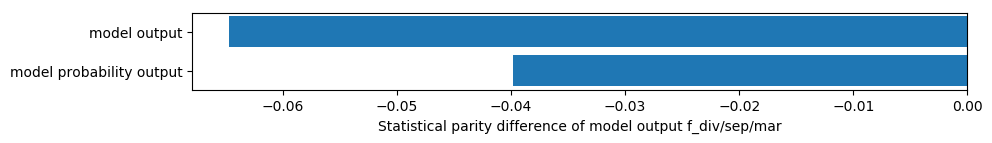

Negative values mean that group a has a higher average predicted outcome than group b
-0.06467123452338021 -0.039852207826258035


In [6]:
attribute = protected_att[0]

#Plot Statistical parity difference Men vs Woman:
data_split = functions.split_data(X_train, y_train, X_test, y_test, model, attribute)
X_train_a, y_train_a, X_test_a, y_test_a, y_pred_a, X_train_b, y_train_b, X_test_b, y_test_b, y_pred_b = data_split
y_pred_prob_a = model.predict_proba(X_test_a)[:,1]
y_pred_prob_b = model.predict_proba(X_test_b)[:,1]


spd = functions.statistical_parity_difference(y_pred_b, y_pred_a)
spd_prob = functions.statistical_parity_difference(y_pred_prob_b, y_pred_prob_a)

bar_plot(["model output", "model probability output"], [spd, spd_prob], 'Statistical parity difference of model output '+ attribute, (10,1))
print("Negative values mean that group a has a higher average predicted outcome than group b")
print(spd, spd_prob)

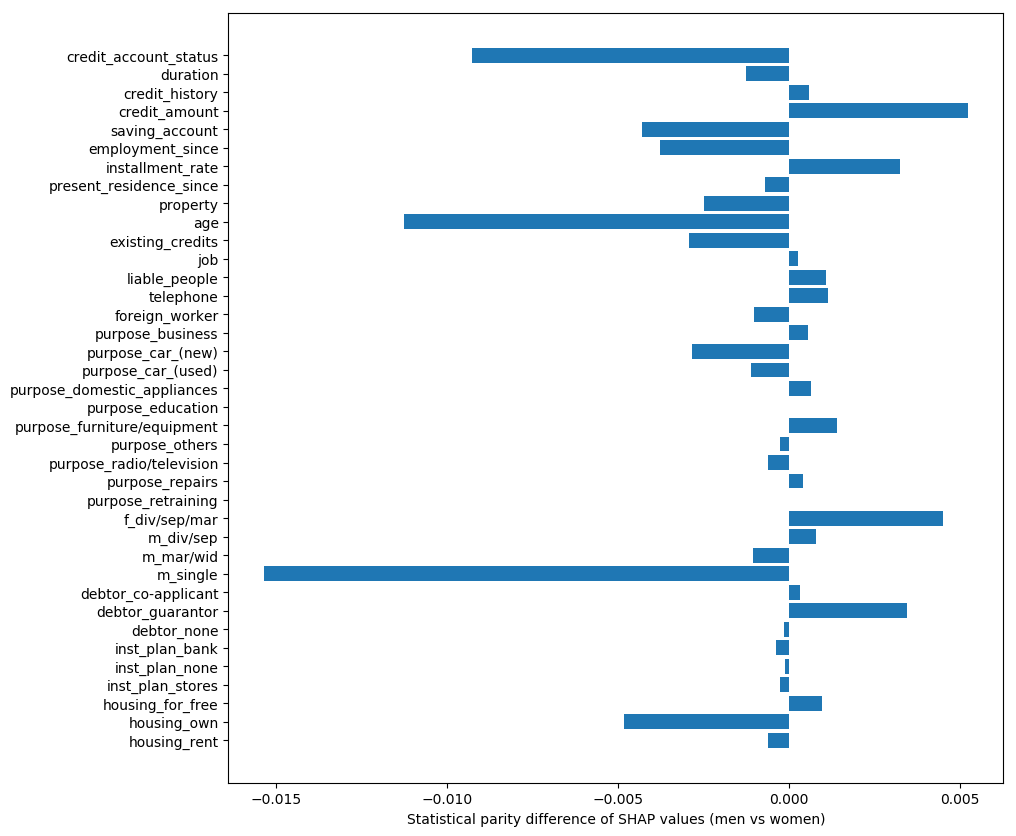

-0.03985220815049188


In [7]:
shap_values_a = []
shap_values_b = []
is_a = np.asarray(X_test[attribute])
for idx, i in enumerate(shap_values[1]):
    if is_a[idx] == 1:
        shap_values_a.append(i)
    else:
        shap_values_b.append(i)
    

    
shap_values_a = np.asarray(shap_values_a)
shap_values_b = np.asarray(shap_values_b)
att = np.asarray(X_train.columns)
val = []
for i in range(len(att)):
    spd = functions.statistical_parity_difference(shap_values_b[:,i], shap_values_a[:,i])
    val.append(spd)
            
bar_plot(att, val, 'Statistical parity difference of SHAP values (men vs women)', (10,10))
sum = 0
for i in val:
    sum+=i
print(sum)


**Conditional Statistical Parity:**

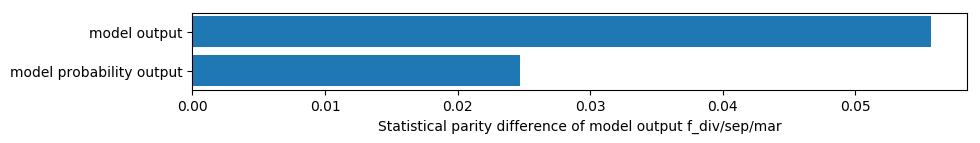

Negative values mean that group a has a higher average predicted outcome than group b
0.05568910256410257 0.024699086076499767


In [8]:
attribute = protected_att[0]

#Plot Statistical parity difference Men vs Woman:
data_split = functions.split_data(X_train, y_train, X_test, y_test, model, attribute)
X_train_a, y_train_a, X_test_a, y_test_a, y_pred_a, X_train_b, y_train_b, X_test_b, y_test_b, y_pred_b = data_split
y_pred_prob_a = model.predict_proba(X_test_a)[:,1]
y_pred_prob_b = model.predict_proba(X_test_b)[:,1]

cspd = functions.conditional_statistical_parity_difference(conditional_att, X_test, X_test_a, y_pred_a, X_test_b, y_pred_b)
cspd_prob = functions.conditional_statistical_parity_difference(conditional_att, X_test, X_test_a, y_pred_prob_a, X_test_b, y_pred_prob_b)

bar_plot(["model output", "model probability output"], [cspd, cspd_prob], 'Statistical parity difference of model output '+ attribute, (10,1))
print("Negative values mean that group a has a higher average predicted outcome than group b")
print(cspd, cspd_prob)

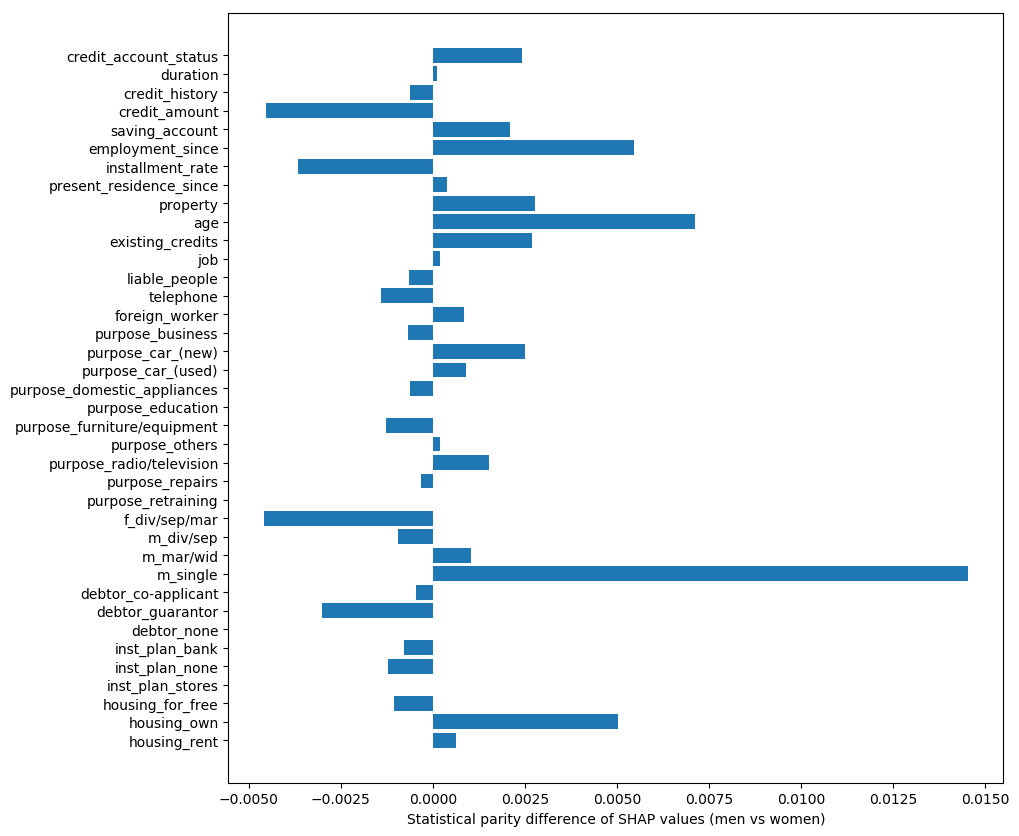

0.024699086475753047


In [9]:
shap_values_a = []
shap_values_b = []
is_a = np.asarray(X_test[attribute])
for idx, i in enumerate(shap_values[1]):
    if is_a[idx] == 1:
        shap_values_a.append(i)
    else:
        shap_values_b.append(i)

shap_values_a = np.asarray(shap_values_a)
shap_values_b = np.asarray(shap_values_b)
att = np.asarray(X_train.columns)
val = []
for i in range(len(att)):
    cspd = functions.conditional_statistical_parity_difference(conditional_att, X_test, X_test_a, shap_values_a[:,i], X_test_b, shap_values_b[:,i])
    val.append(cspd)
            
bar_plot(att, val, 'Statistical parity difference of SHAP values (men vs women)', (10,10))
sum = 0
for i in val:
    sum+=i
print(sum)
